# Introduction to the BART command-line tools


This tutorial introduces the BART command-line inteface (CLI). The CLI tools operate on multidimensional arrays stored in files, and can be stringed together to create complete simulation and reconstruction programs.

### Requirements
- Install bart (version 0.4.04 or newer): https://github.com/mrirecon/bart  
- Set the `TOOLBOX_PATH` to the BART directory and add it to the `PATH`
- If running interactively, add the `view` program to `PATH` for plotting
```bash
export TOOLBOX_PATH=/path/to/bart  
export PATH=$TOOLBOX_PATH:$PATH
export PATH=/path/to/view:$PATH
```

Although the simplest way to call the BART CLI tools is through a terminal, there are also wrapper functions that allow the tools to run through Matlab and Python. These are located under the `$TOOLBOX_PATH/matlab` and `$TOOLBOX_PATH/python` directories.

### DEBUG statements
It is possible to control the level of Debug info that BART commands produce through the `DEBUG_LEVEL` environment variable. By setting this to a number greater than zero, different amounts of output will be seen. A good choice is to set it to 5, which is a balance between too much info and too little.

In [2]:
export DEBUG_LEVEL=5

BART provides a number of tools for MRI image reconstruction and multi-dimensional array manipulation.

In [3]:
# get a list of BART commands by running bart with no arguments:
bart

BART. Available commands are:
avg         bench       bitmask     cabs        caldir      calmat      
carg        casorati    cc          ccapply     cdf97       circshift   
conj        conv        copy        cpyphs      creal       crop        
delta       ecalib      ecaltwo     estdelay    estdims     estshift    
estvar      extract     fakeksp     fft         fftmod      fftshift    
filter      flatten     flip        fmac        homodyne    index       
invert      itsense     join        lrmatrix    mandelbrot  mip         
nlinv       noise       normalize   nrmse       nufft       ones        
pattern     phantom     pics        pocsense    poisson     poly        
repmat      reshape     resize      rof         rss         sake        
saxpy       scale       sdot        show        slice       spow        
sqpics      squeeze     std         svd         threshold   toimg       
traj        transpose   twixread    var         vec         version     
walsh       wave     

: 1

## BART command structure:
### **`bart`** + **`command`** + **`options`** + **`input / output`**

Each BART command comtains a number of optional arguments, followed by input and output files.   
To see all options and requirements of a command, use the `-h` flag:


In [4]:
# Obtain help for each command (-h)
bart toimg -h

Usage: toimg [-g f] [-c f] [-w f] [-d] [-m] [-W] [-h] <input> <output_prefix>

Create magnitude images as png or proto-dicom.
The first two non-singleton dimensions will
be used for the image, and the other dimensions
will be looped over.


-g gamma      	gamma level
-c contrast      	contrast level
-w window      	window level
-d		write to dicom format (deprecated, use extension .dcm)
-m		re-scale each image
-W		use dynamic windowing
-h		help


BART loosely follows the Linux CLI convention, where optional arguments are indicated with brackets, and files are indicated by carrot symbols.

As we can see, there are many CLI tools available. The full descriptions of each program can be found under `$TOOLBOX_PATH/doc/commands.txt`.

## Displaying images

Before getting started, let's make a helper function for displaying images. We will use the BART command `toimg`, which can convert BART files to pngs.

If our session supports X-windows forwarding, we can instead use the BART viewer, `view`, to open an interactive viewer.

Other options for viewing BART files are to use the Python and Matlab wrappers, and use any viewer within those programs.

In [5]:
# BASH function to write BART file to png,
# display the png, and then temove it
function imshow () {
    bart toimg -W $1 $1.png > /dev/null
    cat $1.png | display
    rm $1.png
}

 ## Using BART
 
As a first example, let's create a Shepp-Logan numerical phantom in k-space. We will use the `phantom` tool. Before using the tool, let's look at its options

In [6]:
bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <string>] [-x d] [-G d] [-3] <output>

Image and k-space domain phantoms.

-s nc      	nc sensitivities
-S Output nc sensitivities
-k		k-space
-t file      	trajectory
-x n      	dimensions in y and z
-G n=1,2      	Geometric object phantom
-3		3D
-h		help


The `phantom` tool includes the option `-k` to create it directly in k-space, and `-x` to specify the dimensions.

Shepp-Logan k-space phantom


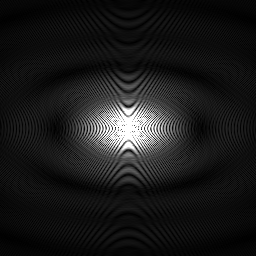

In [7]:
# Create Cartesian k-space phantom (256 samples)
bart phantom -x 256 -k shepp_logan

echo "Shepp-Logan k-space phantom"
imshow shepp_logan
# view  shepp_logan

## Data files
All data files are multi-dimensional arrays. By running the `phantom` command, we made new files on disk, with the names  
`shepp_logan.cfl` and `shepp_logan.hdr`

The data files represent a multi-dimensional array. The `hdr`, or header file, contains the data dimensions and other information about the dataset. The `cfl`, or complex-float file, contains the single-precision raw data in column-major order and interleaved real and imaginary parts.  

The header file is a raw text file and can be opened with any text editor. The complex-float file is a binary file. Matlab and Python readers/writers are available under the `matlab` and `python` directories, respectively.

### View data dimensions
Because the header file is a text file, we can directly print it:

In [8]:
cat shepp_logan.hdr

# Dimensions
256 256 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
# Command
phantom -x 256 -k shepp_logan 
# Files
 >shepp_logan
# Creator
BART v0.4.04-dirty


Although not discussed here, BART can write to other file formats, including a simple H5 container, ISMRMRD format, and others. Therefore, not every format will include a header file. Thus, it is better to use the `show` command.

In [9]:
bart show -h

Usage: show [-m] [-d d] [-s <string>] [-f <string>] <input>

Outputs values or meta data.

-m		show meta data
-d dim      	show size of dimension
-s sep      	use <sep> as the separator
-f format      	use <format> as the format. Default: "%+e%+ei"
-h		help


We can look at an individual dimension of the data with the `-d` command, or we can display all the meta data about the dataset. 

Next, we show the dimensions of the created Shepp-Logan phantom

In [10]:
bart show -m shepp_logan

Type: complex float
Dimensions: 16
AoD:	256	256	1	1	1	1	1	1	1	1	1	1	1	1	1	1


Our dataset is 16-dimensional, but only the first two dimensions are non-singleton.

By convention, the dimensions are `[X, Y, Z, C, M, T, F, ...]`,
where `(X, Y, Z)` are the spatial matrix dimensions,  
`C` and `M` are the coil dimensions and ESPIRiT maps dimensions, respectively,  
`T` and `F` are used for echo times and coefficient dimensions,   
and other higher order dimensions such as phase, flow encode, etc.

## Bitmasks
Let's reconstruct our k-space phantom. using a simple inverse Fourier transform.  
Therefore, we perform a Fast Fourier Transform (FFT).

BART has an `fft` tool for doing just that.

IFFT of Shepp-Logan phantom


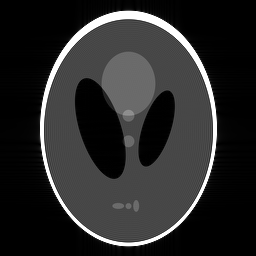

In [11]:
# Perform FFT reconstruction
bart fft -u -i 3 shepp_logan shepp_logan_rec

echo "IFFT of Shepp-Logan phantom"
imshow shepp_logan_rec
# view shepp_logan_rec

Let's see the fft-options.

In [12]:
# Show help for fft command
bart fft -h

Usage: fft [-u] [-i] [-n] bitmask <input> <output>

Performs a fast Fourier transform (FFT) along selected dimensions.

-u		unitary
-i		inverse
-n		un-centered
-h		help


Thus, we performed an inverse (`-i`) unitary (`-u`) Fast Fourier Transform on the image dimensions **`(0, 1)`** specified by the bitmask **`3`**.


Instead of using for loops, BART data operates on bitmasks. To operate on a particular array dimension, a bitmask specifies the active dimensions. This is a powerful approach for perfoming multi-dimensional operations, as all the tools will work on arbitrarily chosen dimensions.   

In our case, we wanted to perform an IFFT along dimensions 0 and 1, and the bitmask is calculated as:  
<center>
$ \text{bitmask}=2^{~0} + 2^{~1} = 3$
</center> <br>
BART also provides a command-line tool to calculate the bitmasks for specific dimensions.

In [ ]:
# Calculate bitmask for active dimensions 0 and 1
bart bitmask 0 1

## BART Examples
### Low-Pass Filtering

Here, we create and apply a simple mask to low-pass filter the k-space phantom. We use the `ones` tool to make an array of all-ones, and then zero-pad it to the full k-space matrix size

In [1]:
# Create a mask consisting of ones with two dimensions: (256, 30)
bart ones 2 256 30 mask_center

# Zero-pad the second (index 1) dimension to the full k-space dimension 
bart resize -c 1 256 mask_center mask_full

echo "low-pass filter mask"
# view mask_full
imshow mask_full

low-pass filter mask
bash: imshow: command not found


: 127

Now let's multiply our data with the mask. To perform the multiplication, we use the `fmac` tool, which stands for **Fused Multiply-Accumulate**. The `fmac` tool is a very powerful way of multiplying two multi-dimensional arrays, and then summing along specific dimension. In this way, we can perform simple multiplication, through vector and matrix multiplications, all the way to tensor products.

In [ ]:
# Multiply mask with k-space
bart fmac shepp_logan mask_full shepp_logan_lp

echo "Low-pass filtered k-space"
imshow shepp_logan_lp
# view shepp_logan_lp

We repeat the unitary inverse FFT on our dataset:

In [ ]:
# Reconstruction of low-pass filtered k-space data
bart fft -u -i 3 shepp_logan_lp shepp_logan_lp_reco

echo 'Low-pass filtered reconstruction'
imshow shepp_logan_lp_reco
# view shepp_logan_lp_reco

### Undersampling Artifacts

Now let's consider downsampling k-space by a factor of `R` which is common in parallel imaging. To do this with BART, we will string together multiple commands

In [2]:
# Create Cartesian undersampling pattern (2x undersampling with 20 auto-calibration lines)

R=4 #Define undersampling factor as powers of 2

# Create local pattern, assuming homogeneous undersampling in one dimension
bart ones 2 256 1 ones
bart zeros 2 256 1 zeros

bart join 1 $(seq 1 $R | xargs  -I{} echo ones) $(seq 1 $R | xargs -I{}  echo zeros) pattern

# Repeat local pattern to get undersampling pattern
bart repmat 2 $((128/R)) pattern tmp
bart reshape $(bart bitmask 1 2) 256 1 tmp grid

echo "Sampling pattern"
imshow grid


# Multiply undersampling pattern with image
bart fmac shepp_logan grid shepp_us

echo "Under-sampled k-space data"
imshow shepp_us

loading ones
loading ones
loading ones
loading ones
loading zeros
loading zeros
loading zeros
loading zeros
done copying file 2
done copying file 4
done copying file 6
done copying file 5
done copying file 0
done copying file 3
done copying file 7
done copying file 1
Sampling pattern
bash: imshow: command not found
Under-sampled k-space data
bash: imshow: command not found


: 127

When we reconstruct the data with an IFFT, what do we expect to see?

In [ ]:
# Reconstruction of undersampled k-space data
bart fft -u -i 3 shepp_us shepp_us_reco

echo "Under-sampled reconstruction"
imshow shepp_us_reco

### Reconstruction of Multi-Coil Data
Now, let's create and reconstruct multi-coil data. We will again use the `phantom` command, but this time we will pass the `-s` flag to indicate that we want multiple channels.

We will also add complex-valued Gaussian noise with the `noise` tool, and coil-compress the channels using a software coil compression method with the `cc` tool.

In [3]:
# Create a k-space phantom with multiple (8) coils
bart phantom -x 256 -s 8 -k shepp_coils

In [4]:
# Add Gaussian white noise to the k-space, multi-coil phantom
bart noise -n 2 shepp_coils shepp_noise

In [5]:
# Compress to 4 coils
bart cc -p 4 shepp_noise shepp_cc

Calibration region...  (size: 24x24x1, pos: 116x116x0)
Energy: 0.591 0.285 0.103 0.015 0.004 0.001 0.000 0.000
Compressing to 4 virtual coils...
Done.


In [6]:
# Reconstruct noisy phantom
bart fft -u -i $(bart bitmask 0 1) shepp_cc shepp

In [7]:
# Slice out one coil-image of the reconstructed k-space phantom and display.
bart slice 3 0 shepp shepp_coil0
echo "Coil image 0"
imshow shepp_coil0

Coil image 0
bash: imshow: command not found


: 127

In [ ]:
# Reshape the coil images for displaying. We will concatenate the row dimension with the coil dimension  
bart reshape $(bart bitmask 1 3) 1024 1 shepp shepp_flat
echo "Coil images"
imshow shepp_flat

In [ ]:
# Combine coils (Root-Sum-of-Squares)
bart rss $(bart bitmask 3) shepp shepp_rss

echo "RSS result"
imshow shepp_rss
# view shepp_rss shepp_coil0

# Parallel Imaging Compressed Sensing

One of the most useful functions of BART is the ability to perform parallel imaging calibration and compressed sensing (PICS) reconstructions, including estimating sensitivity maps with ESPIRiT.

BART allows to perform a Parallel Imaging Compressed Sensing reconstruction using the **`bart pics`** command. You can specify a variety of different regularization terms and solvers by simply specifying the respective flags.
Here, we demonstrate how to perform a PICS reconstruction on synthetic data.  

We will reuse the coil-compressed k-space data from the previous section

In [ ]:
# Display k-space phantom
bart reshape $(bart bitmask 1 3) 1024 1 shepp_cc shepp_flat
echo "multi-channel k-space phantom"
imshow shepp_flat

Next, we create an undersampling pattern. Since we want to demonstrate Compressed Sensing, we choose a Poisson-Disc undersampling pattern with 2x2 in-plane acceleration and an Auto-calibration region of 32x32 samples.

In [ ]:
# Create Poisson-Disc undersampling pattern

# 2x2-fold in-plane acceleration. Auto-calibration region: 32x32
bart poisson -Y 256 -y 2 -Z 256 -z 2 -C 32 -e poisson

# Reshape into required dimensions to match the k-space
bart squeeze poisson poisson

# Show pattern
echo "Poisson-disc sampling pattern"
imshow poisson

We simulate an undersampled k-space by applying the pattern to the fully-sampled k-space phantom.

In [ ]:
# Multiply pattern and k-space to obtain undersampled k-space
bart fmac shepp_cc poisson shepp_usamp

# Show undersampled k-space phantom
bart reshape $(bart bitmask 1 3) 1024 1 shepp_usamp shepp_usamp_flat
echo "under-sampled k-space"
imshow shepp_usamp_flat

Note that the undersampling pattern was automatically applied to each coil! This is the beauty of the `fmac` tool.  
First, we perform a conventional inverse Fourier Transform and Root-Sum-of-Squares reconstruction.

In [ ]:
# Conventional FFT-reconstruction

# Perform conventional inverse FFT reconstruction
bart fft -i -u $(bart bitmask 0 1) shepp_usamp shepp_fft

# Combine coils by Root-Sum-of-Squares
bart rss $(bart bitmask 3) shepp_fft shepp_fft_rss

# Show FFT reconstruction
echo "Linear reconstruction"
imshow shepp_fft_rss

The result is - of course - not very pleasing. The image is corrupted by ringing and noise-like artifacts. <br>
So, lets try a more advanced reconstruction technique. We therefore need to determine the coil sensitivities. We therefore use the ESPIRiT approach to obtain one map for each coil.

In [8]:
# Iterative Parallel Imaging Reconstruction with different regularization terms

# Compute sensitivity maps using ESPIRiT (constrained to a single map)
# change the DEBUG_LEVEL for this command to reduce the output
DEBUG_LEVEL=4 bart ecalib -m1 shepp_usamp sens

# Show sensitivity maps
bart reshape $(bart bitmask 1 3) 1024 1 sens sens_flat
echo "Estimated sensitivity maps with ESPIRiT"
imshow sens_flat

Calibration region...  (size: 24x24x1, pos: 116x116x0)
Energy: 0.595 0.286 0.104 0.015
Build calibration matrix and SVD...
Eigen decomposition... (size: 144)
Using 47/144 kernels (32.64%, last SV: 0.032712).
Zeropad...
FFT (juggling)...
Calculate Gram matrix...
Resize...
Point-wise eigen-decomposition...
Crop maps... (c = 0.80)
Fix phase...
Done.
Estimated sensitivity maps with ESPIRiT
bash: imshow: command not found


: 127

Given the sensitivities, the **`bart pics`** command allows an iterative Parallel Imaging reconstruction using different regularization terms. It solves the following minimization problem:

$$\min_x \frac{1}{2} \| F_u S x - y \|_2^2 + R(x) $$
- $F_u$ is the (undersampled) DFT operator
- $S$ is the multi-channel sensitivity operator
- $x$ is the desired image
- $y$ is the acquired kspace data
- $R$ is the desired regularization term

A popular regularization is Tikhonov (L2) with
$$R(x) = \frac{\lambda}{2}  \| x \|_2^2  $$

with regularization parameter $\lambda$. 

In [9]:
lambda=0.005
iter=50

# Parallel Imaging reconstruction using L2 regularization
DEBUG_LEVEL=5 bart pics -S -l2 -r$lambda -i $iter shepp_usamp sens shepp_l2

# Show L2 and Wavelet reconstructions
echo "L2 Regularization"
imshow shepp_l2


Size: 65536 Samples: 13644 Acc: 4.80
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Calibration region...  (size: 32x32x1, pos: 112x112x0)
Scaling: 644.484558! (max = 644.484558/p90 = 183.449295/median = 43.066902)
Inverse scaling of the data: 644.484558
l2 regularization: 0.005000
conjugate gradients
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
#0: 52.615627
#1: 4.844840
#2: 1.873068
#3: 1.125854
#4: 0.671931
#5: 0.472993
#6: 0.327247
#7: 0.243088
#8: 0.188450
#9: 0.142078
#10: 0.112799
#11: 0.089352
#12: 0.070982
#13: 0.058000
#14: 0.046580
#15: 0.037910
#16: 0.030471
#17: 0.025459
#18: 0.021277
#19: 0.017463
#20: 0.014611
#21: 0.012130
#22: 0.010200
#23: 0.008461
#24: 0.007037
#25: 0.005974
#26: 0.005075
#27: 0.004330
#28: 0.003622
#29: 0.003116
#30: 0.002716
#31: 0.002308
#32: 0.001956
#33: 0.001664
#34: 0.001410
#35: 0.001204
#36: 0.001031
#37: 

: 127

The result is definitely better than the conventional FFT reconstruction, but still undersampling artifacts are visible.<br><br>
We therefore try another regularization term: L1 Wavelets
 $$ R(x) = \lambda \| \Psi x \|_1$$


In [10]:
lambda=0.005
iter=50

# Parallel Imaging Compressed Sensing reconstruction using WAVELET regularization
bart pics -S -R W:$(bart bitmask 0 1):0:$lambda -i $iter shepp_usamp sens shepp_wavelet

# Show Wavelet reconstructions
echo "L1 Wavelet Regularization"
imshow shepp_wavelet


Size: 65536 Samples: 13644 Acc: 4.80
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Calibration region...  (size: 32x32x1, pos: 112x112x0)
Scaling: 644.484558! (max = 644.484558/p90 = 183.449295/median = 43.066902)
Inverse scaling of the data: 644.484558
l1-wavelet regularization: 0.005000
FISTA
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
#It 000: 1.000000   
#It 001: 0.225656   
#It 002: 0.054369   
#It 003: 0.025167   
#It 004: 0.017820   
#It 005: 0.014175   
#It 006: 0.012475   
#It 007: 0.012375   
#It 008: 0.012228   
#It 009: 0.011422   
#It 010: 0.011153   
#It 011: 0.011139   
#It 012: 0.010823   
#It 013: 0.010887   
#It 014: 0.010693   
#It 015: 0.011291   
#It 016: 0.011616   
#It 017: 0.011856   
#It 018: 0.011943   
#It 019: 0.011418   
#It 020: 0.011857   
#It 021: 0.011434   
#It 022: 0.012070   
#It 023: 0.011145   
#It 024: 0.01123

: 127

A list of available regularization terms can be displayed using the option `-Rh`

In [11]:
bart pics -Rh

Generalized regularization options (experimental)

-R <T>:A:B:C	<T> is regularization type (single letter),
		A is transform flags, B is joint threshold flags,
		and C is regularization value. Specify any number
		of regularization terms.

-R Q:C    	l2-norm in image domain
-R I:B:C  	l1-norm in image domain
-R W:A:B:C	l1-wavelet
-R N:A:B:C	Normalized Iterative Hard Thresholding (NIHT), image domain
		C is an integer percentage, i.e. from 0-100
-R H:A:B:C	NIHT, wavelet domain
-R F:A:B:C	l1-Fourier
-R T:A:B:C	total variation
-R T:7:0:.01	3D isotropic total variation with 0.01 regularization.
-R L:7:7:.02	Locally low rank with spatial decimation and 0.02 regularization.
-R M:7:7:.03	Multi-scale low rank with spatial decimation and 0.03 regularization.


## Conclusion
This concludes the introduction to the BART tools. Additional demos showcase more advanced reconstruction methods, including dynamic imaging with spatio-temporal regularization.